# 2021-11-29b Some minor fixes

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

In follow up to the notes from 2021-11-27, I have now also:
* Set `sc_scenario_helper.ANTICIPATION_TIME_STEP` = 0.025 s.
* Modified to protect properly against predicted reversing in `SCAgent.get_predicted_other_state()`.
* I have also updated `sc_scenario.get_entry_exit_times()` to use the same code regardless of whether considering accelerations or not (helper function `sc_scenario_helper.get_time_to_dist_with_acc()`), and not permitting any negative speeds.

As noted in the SCPaper README I did look into the possibility of also addressing the point about whether or not A should assume that B sees A's accelerations when judging values of B's behaviours, and not doing so in the `oVAa` model led to some awkward inconsistencies in the model outputs and behaviours, so I am leaving that be for the moment.

Next step now is to rerun (at least some of) the deterministic fits from 2021-11-26, to see the impact of the improvements hopefully) made over the last few days...

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
    sys.path.append(parent_path + '/SCPaper')
print(sys.path)

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
import sc_scenario_perception
from sc_scenario_helper import CtrlType

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework', 'C:\\GITHUB\\COMMOTIONSFramework/SCPaper']


## Unit tests, reproducing earlier results

### Basics - check!

Just the base model, no interaction.

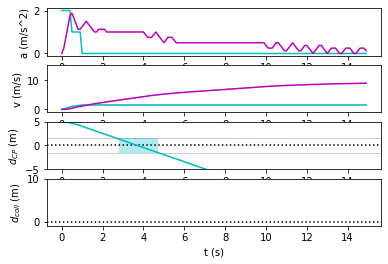

In [2]:
NAMES = ('P', 'V')
WIDTHS = (1.5, 1.5) # setting widths/lengths corresponding to the old default
LENGTHS = (1.5, 1.5) # setting sc_scenario.SHARED_PARAMS.d_C = 1.5
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = sc_scenario.SCSimulation(
        CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. 

Interestingly, now, with the smaller `ANTICIPATION_TIME_STEP`, I get back the exact same model behaviour as in the 2021-10-19 notes, which were not 100% reproduced in the 2021-10-21 notes, when I first tested the numerical integration. So this 0.025 s step seems a more sensible choice also in this sense.

Initial car distance 30 m:


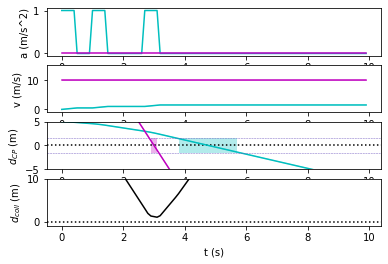

Initial car distance 40 m:


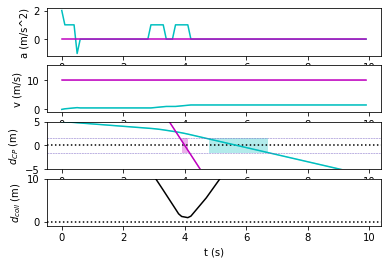

Initial car distance 50 m:


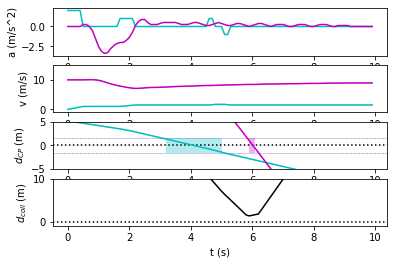

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), 
                            plot_beh_probs = False, plot_beh_activs = False, 
                            plot_beh_accs = False, plot_looming = False, 
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = sc_scenario.SCSimulation(
                CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

And here is the same after restoring the pre-safety-margin settings. 

Again this is a return to exact reproduction of the pre-numerical-integration results; compare to the 2021-10-13 notes which weren't 100% reproduced in 2021-10-21.

Initial car distance 30 m:


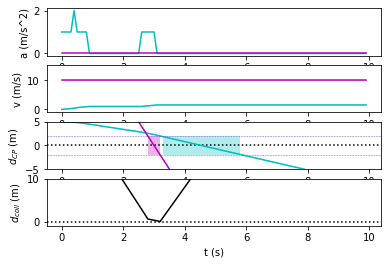

Initial car distance 40 m:


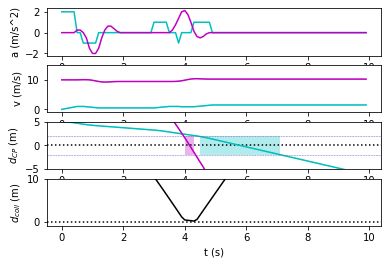

Initial car distance 50 m:


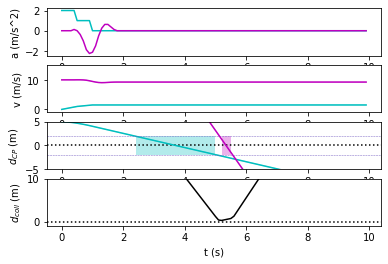

In [4]:
WIDTHS = (2, 2) # setting widths/lengths corresponding to the old default
LENGTHS = (2, 2) # setting sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
run_baseline_kinematics()

### Testing the `oBEo` etc sequence - check!

Getting back the same results as in the 2021-11-09 notes:

Turning on oBEo:
Initial car distance 40 m:


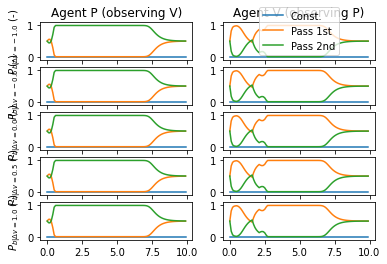

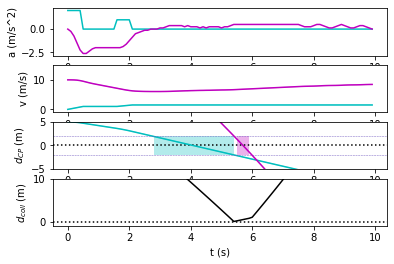

Turning on oBEv:
Initial car distance 40 m:


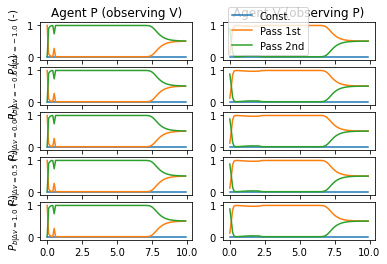

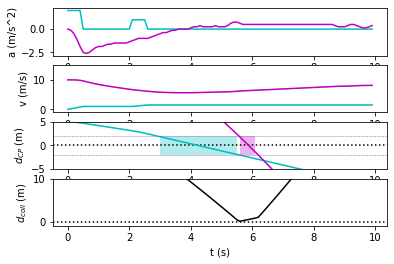

Turning on oAI:
Initial car distance 40 m:


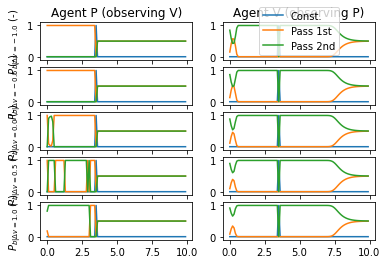

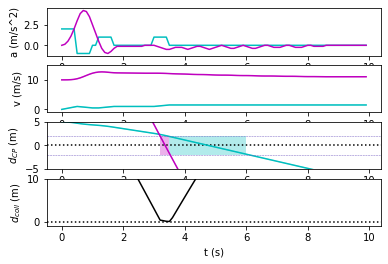

In [5]:
params.T_O1 = 0.1 
params.T_Of = 0.5
params.sigma_O = 0.01
params.beta_V = 160

def run_oBEo_etc_seq():
    global optional_assumptions
    print('Turning on oBEo:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oBEv:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oAI:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True, oAI = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
run_oBEo_etc_seq()